# LIBRERIAS

In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# EXTRACCION DATOS

In [18]:
df_max = pd.read_csv("datos_tem_max.csv")
df_min = pd.read_csv("datos_tem_min.csv")

# Unir en un solo DataFrame para análisis conjunto (opcional)
df_all = pd.concat([df_max.assign(Tipo="Max"), 
                    df_min.assign(Tipo="Min")], 
                   ignore_index=True)

In [20]:
df_all.head()

,CodigoEstacion,Departamento,NombreEstacion,Variable,Parametro,Fecha,Unidad,Valor,NivelAprobacion,Tipo
0,26125061,Quindio,AEROPUERTO EL EDEN - - AUT [26125061],TEMPERATURA,Temperatura máxima media mensual,1/01/2010 0:00,degC,29.492473,Preliminar,Max
1,26125061,Quindio,AEROPUERTO EL EDEN - - AUT [26125061],TEMPERATURA,Temperatura máxima media mensual,1/02/2010 0:00,degC,30.364286,Preliminar,Max
2,26125061,Quindio,AEROPUERTO EL EDEN - - AUT [26125061],TEMPERATURA,Temperatura máxima media mensual,1/03/2010 0:00,degC,30.215591,Preliminar,Max
3,26125061,Quindio,AEROPUERTO EL EDEN - - AUT [26125061],TEMPERATURA,Temperatura máxima media mensual,1/04/2010 0:00,degC,27.836944,Preliminar,Max
4,26125061,Quindio,AEROPUERTO EL EDEN - - AUT [26125061],TEMPERATURA,Temperatura máxima media mensual,1/05/2010 0:00,degC,28.433602,Preliminar,Max


In [22]:
df = df_all.drop(columns=['CodigoEstacion', 'NombreEstacion','Variable', 'Parametro', 'Unidad', 'NivelAprobacion','Departamento'])

In [24]:
# Convertir fecha
# df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y %H:%M", errors="coerce")
# Asegurar Valor como numérico
df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")

df["AnioMes"] = df["Fecha"].dt.to_period("M")

# COMPLETITUD

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10055 entries, 0 to 10054
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    10055 non-null  datetime64[ns]
 1   Valor    10055 non-null  float64       
 2   Tipo     10055 non-null  object        
 3   AnioMes  10055 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), object(1), period[M](1)
memory usage: 314.3+ KB


In [29]:
df.head()

,Fecha,Valor,Tipo,AnioMes
0,2010-01-01,29.492473,Max,2010-01
1,2010-02-01,30.364286,Max,2010-02
2,2010-03-01,30.215591,Max,2010-03
3,2010-04-01,27.836944,Max,2010-04
4,2010-05-01,28.433602,Max,2010-05


In [31]:
print("\n=== COMPLETITUD ===")
print("\nPorcentaje de valores faltantes:")
print(df.isna().mean().sort_values(ascending=False))

print("\nTotal de valores faltantes:")
print(df.isna().sum())




=== COMPLETITUD ===

Porcentaje de valores faltantes:
Fecha      0.0
Valor      0.0
Tipo       0.0
AnioMes    0.0
dtype: float64

Total de valores faltantes:
Fecha      0
Valor      0
Tipo       0
AnioMes    0
dtype: int64


In [35]:

# 2. COMPLETITUD TEMPORAL MES A MES
# ---------------------------
print("\n=== COMPLETITUD MENSUAL ===")

# Total de records por (mes, tipo)
conteo_mes = df.groupby(["AnioMes", "Tipo"]).size().unstack(fill_value=0)
print("\nRegistros por mes y tipo (Max/Min):")
print(conteo_mes)

# Detectar meses con más de 1 registro por tipo
duplicados_mes = conteo_mes[(conteo_mes > 1).any(axis=1)]
print("\nMeses con más de 1 registro por tipo (requieren promedio):")
print(duplicados_mes)
# Detectar meses faltantes por tipo
faltantes_mes = conteo_mes[(conteo_mes == 0).any(axis=1)]
print("\nMeses sin registros de Max o Min (faltantes):")
print(faltantes_mes)

# ---------------------------
# 3. PROMEDIO AUTOMÁTICO POR MES SI HAY MULTIPLES REGISTROS
# ---------------------------
df_mensual = (
    df.groupby(["AnioMes", "Tipo"])["Valor"]
      .mean()   # promediar si hay más de un valor
      .reset_index()
)

print("\n=== BASE AGREGADA (1 valor por mes y tipo) ===")
print(df_mensual.head())

# Pivot para ver estructura final
df_pivot = df_mensual.pivot(index="AnioMes", columns="Tipo", values="Valor")
print("\nBase final con columnas Max y Min:")
print(df_pivot.head())

# ---------------------------
# 4. RESUMEN
# ---------------------------
print("\n======= RESUMEN FINAL =======")
print(f"Registros totales: {len(df)}")
print(f"Registros únicos mensuales tras agregación: {len(df_mensual)}")
print(f"Años cubiertos: {df['Fecha'].dt.year.min()} - {df['Fecha'].dt.year.max()}")
print(f"Meses completos (Max y Min): {(conteo_mes.min(axis=1) > 0).sum()}")
print(f"Meses incompletos: {(conteo_mes.min(axis=1) == 0).sum()}")


=== COMPLETITUD MENSUAL ===

Registros por mes y tipo (Max/Min):
Tipo     Max  Min
AnioMes          
2010-01   25   29
2010-02   25   29
2010-03   24   29
2010-04   25   30
2010-05   25   30
...      ...  ...
2025-07   18   19
2025-08   19   20
2025-09   19   19
2025-10   18   17
2025-11   11   12

[191 rows x 2 columns]

Meses con más de 1 registro por tipo (requieren promedio):
Tipo     Max  Min
AnioMes          
2010-01   25   29
2010-02   25   29
2010-03   24   29
2010-04   25   30
2010-05   25   30
...      ...  ...
2025-07   18   19
2025-08   19   20
2025-09   19   19
2025-10   18   17
2025-11   11   12

[191 rows x 2 columns]

Meses sin registros de Max o Min (faltantes):
Empty DataFrame
Columns: [Max, Min]
Index: []

=== BASE AGREGADA (1 valor por mes y tipo) ===
   AnioMes Tipo      Valor
0  2010-01  Max  23.458309
1  2010-01  Min  13.205375
2  2010-02  Max  23.468954
3  2010-02  Min  14.211030
4  2010-03  Max  23.531380

Base final con columnas Max y Min:
Tipo           Max 

In [41]:
df_mensual.head()

,AnioMes,Tipo,Valor
0,2010-01,Max,23.458309
1,2010-01,Min,13.205375
2,2010-02,Max,23.468954
3,2010-02,Min,14.211030
4,2010-03,Max,23.531380


In [51]:
df_mensual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   AnioMes  382 non-null    period[M]
 1   Tipo     382 non-null    object   
 2   Valor    382 non-null    float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 9.1+ KB


# CONSISTENCIA

In [49]:
resumen_tipo = (
    df_mensual.groupby("Tipo")["Valor"]
              .describe()
)

print("\n=== RESUMEN ESTADÍSTICO POR TIPO ===")
print(resumen_tipo)


=== RESUMEN ESTADÍSTICO POR TIPO ===
      count       mean       std        min        25%        50%        75%  \
Tipo                                                                           
Max   191.0  22.209946  0.764450  20.111629  21.719834  22.137488  22.696809   
Min   191.0  13.470080  0.561306  11.815132  13.119704  13.492547  13.851119   

            max  
Tipo             
Max   24.212248  
Min   15.039543  



=== REGLAS DE RANGO ===

Registros donde Min > Max:
Empty DataFrame
Columns: [Max, Min, Diff, z_Max, z_Min]
Index: []

Registros fuera del rango climatológico razonable (-10°C a 45°C):
Empty DataFrame
Columns: [Max, Min, Diff, z_Max, z_Min]
Index: []

Outliers según Z-score (>|3|):
Empty DataFrame
Columns: [Max, Min, Diff, z_Max, z_Min]
Index: []

Outliers por IQR (Max):
Tipo           Max        Min       Diff     z_Max     z_Min
AnioMes                                                     
2016-01  24.212248  13.835923  10.376324  2.626155  0.653484
2022-06  20.111629  12.377764   7.733866 -2.752084 -1.951141

Outliers por IQR (Min):
Tipo           Max        Min       Diff     z_Max     z_Min
AnioMes                                                     
2016-03  23.777313  15.039543   8.737769  2.055708  2.803439
2025-09  22.044376  11.815132  10.229243 -0.217156 -2.956136


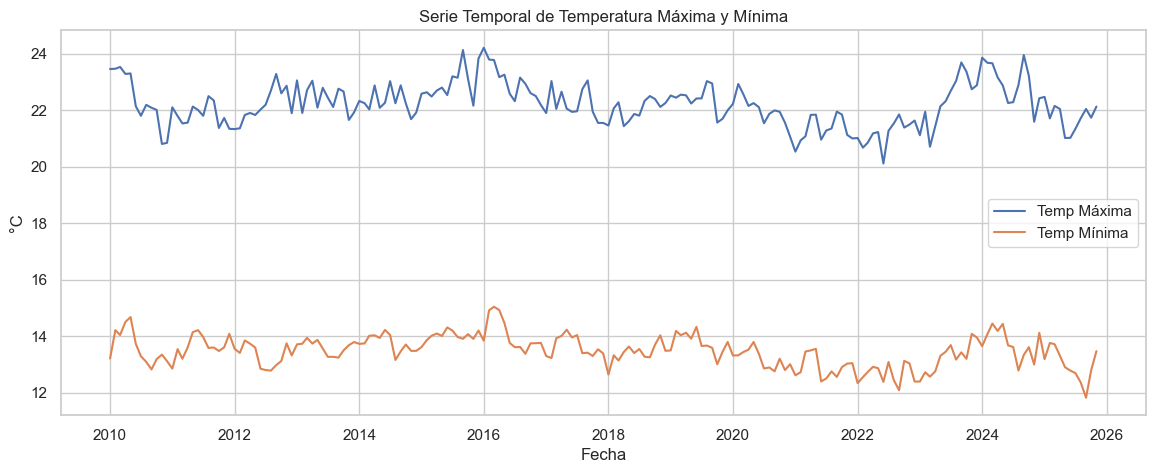

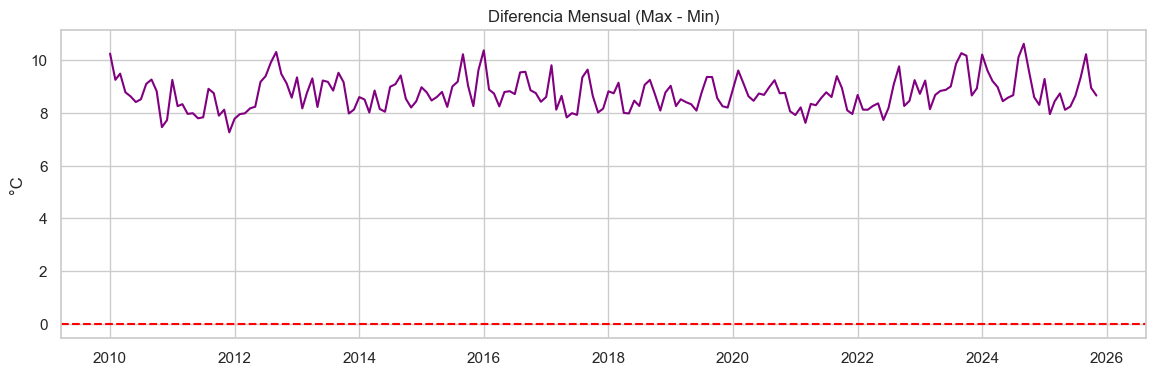

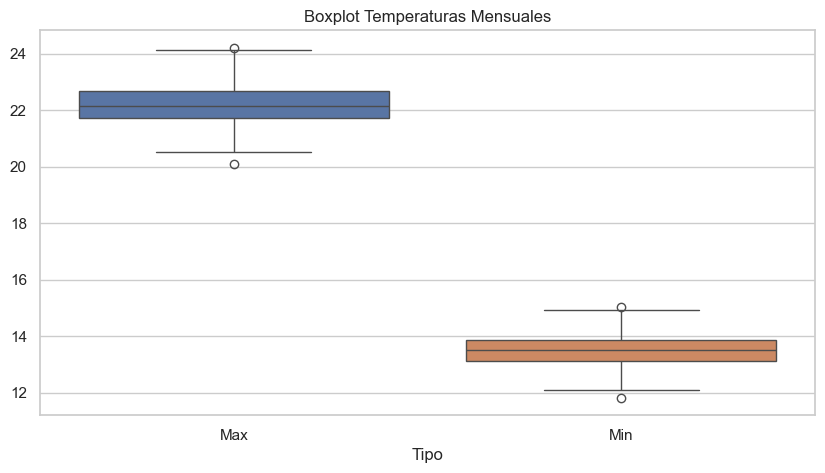

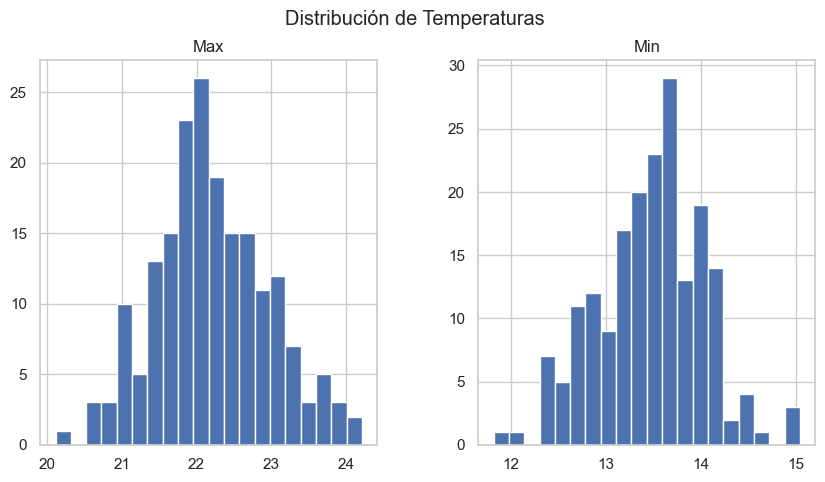

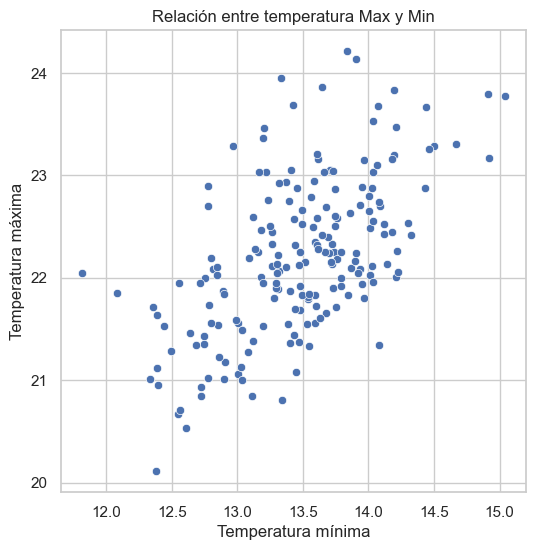

In [47]:
# ================================
# 1. REGLAS DE RANGO ESPERADO
# ================================
df_pivot["Diff"] = df_pivot["Max"] - df_pivot["Min"]

print("\n=== REGLAS DE RANGO ===")

# Maxima menor que Minima → ERROR GRAVE
errores_inversion = df_pivot[df_pivot["Diff"] < 0]
print("\nRegistros donde Min > Max:")
print(errores_inversion)

# Rango físico razonable para Colombia
rango_error = df_pivot[
    (df_pivot["Max"] > 45) | 
    (df_pivot["Min"] < -10)
]

print("\nRegistros fuera del rango climatológico razonable (-10°C a 45°C):")
print(rango_error)

# ================================
# 2. OUTLIERS (Z-SCORE)
# ================================
from scipy.stats import zscore

df_pivot["z_Max"] = zscore(df_pivot["Max"])
df_pivot["z_Min"] = zscore(df_pivot["Min"])

outliers_z = df_pivot[(df_pivot["z_Max"].abs() > 3) | (df_pivot["z_Min"].abs() > 3)]

print("\nOutliers según Z-score (>|3|):")
print(outliers_z)

# ================================
# 3. OUTLIERS (IQR)
# ================================
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return (serie < lower) | (serie > upper)

outliers_iqr_max = df_pivot[detectar_outliers_iqr(df_pivot["Max"])]
outliers_iqr_min = df_pivot[detectar_outliers_iqr(df_pivot["Min"])]

print("\nOutliers por IQR (Max):")
print(outliers_iqr_max)

print("\nOutliers por IQR (Min):")
print(outliers_iqr_min)


# ================================
# 4. GRÁFICOS PARA CONSISTENCIA
# ================================

# --- A. Series temporales ---
plt.figure(figsize=(14,5))
plt.plot(df_pivot.index.to_timestamp(), df_pivot["Max"], label="Temp Máxima")
plt.plot(df_pivot.index.to_timestamp(), df_pivot["Min"], label="Temp Mínima")
plt.title("Serie Temporal de Temperatura Máxima y Mínima")
plt.xlabel("Fecha")
plt.ylabel("°C")
plt.legend()
plt.show()

# --- B. Temperatura Max - Min ---
plt.figure(figsize=(14,4))
plt.plot(df_pivot.index.to_timestamp(), df_pivot["Diff"], color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.title("Diferencia Mensual (Max - Min)")
plt.ylabel("°C")
plt.show()

# --- C. Boxplots para revisar distribución ---
plt.figure(figsize=(10,5))
sns.boxplot(data=df_pivot[["Max","Min"]])
plt.title("Boxplot Temperaturas Mensuales")
plt.show()

# --- D. Histogramas ---
df_pivot[["Max","Min"]].hist(figsize=(10,5), bins=20)
plt.suptitle("Distribución de Temperaturas")
plt.show()

# --- E. Gráfico de dispersión Max vs Min ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=df_pivot["Min"], y=df_pivot["Max"])
plt.xlabel("Temperatura mínima")
plt.ylabel("Temperatura máxima")
plt.title("Relación entre temperatura Max y Min")
plt.show()